<a href="https://colab.research.google.com/github/yoojy31/pytorch-object-detection-tutorial/blob/main/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
# drive._mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
%cd "/content/"
!wget "https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip"

!unzip -qq "PennFudanPed.zip"

print('\n\n /content/ 경로의 파일과 폴더 리스트', os.listdir('/content/'))
print(' /content/PennFudanPed/ 경로의 파일과 폴더 리스트', os.listdir('PennFudanPed/'), '\n\n')

%cd /content

/content
--2022-01-22 06:48:49--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M   221MB/s    in 0.2s    

2022-01-22 06:48:49 (221 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]



 /content/ 경로의 파일과 폴더 리스트 ['.config', 'PennFudanPed.zip', 'drive', 'PennFudanPed', 'sample_data']
 /content/PennFudanPed/ 경로의 파일과 폴더 리스트 ['PNGImages', 'Annotation', 'added-object-list.txt', 'PedMasks', 'readme.txt'] 


/content


In [3]:
# 데이터를 구글 드라이브에 직접 업로드한 경우
# !cp "/content/drive/MyDrive/Colab Notebooks/Data/PennFudanPed.zip" "/content/PennFudanPed.zip" 
# !unzip -qq "/content/PennFudanPed.zip"
# print(os.listdir('/content/PennFudanPed/'))

In [4]:
%cd /content/drive/MyDrive/Colab Notebooks
!git clone https://github.com/yoojy31/pytorch-object-detection-tutorial.git  # 외부에서 clone 해옴

/content/drive/MyDrive/Colab Notebooks
Cloning into 'pytorch-object-detection-tutorial'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 55 (delta 17), reused 29 (delta 3), pack-reused 0
Unpacking objects: 100% (55/55), done.


In [5]:
# clone 해온 코드를 import 하기 위함
# 너무 복잡한 부분은 외부에서 불러오고, colab 에서는 생략

%cd 'pytorch-object-detection-tutorial'
import engine, utils
import transforms as T
%cd /content 

/content/drive/MyDrive/Colab Notebooks/pytorch-object-detection-tutorial
/content


In [6]:
# 필요한 라이브러리

import os
import sys
import math

import numpy as np
import torch
import torch.nn as nn
from PIL import Image

import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead
from torchvision.models.detection.faster_rcnn import TwoMLPHead, FastRCNNPredictor

In [7]:
def main(model_name='faster_rcnn', num_epochs=5):  # 전체 코드 구조를 먼저 만든 후, 각 요소들을 만들 예정.
    # model_name option
    #     faster_rcnn : full modeling and weight initialization
    #     pretrained_faster_rcnn : coco-pretrained. faster rcnn
    #     pretrained_ssd : coco-trained. ssdlite320_mobilenet_v3_large

    # Data Loader
    data_loader_train, data_loader_test = create_dataset_and_dataloader(root='PennFudanPed')

    # Model
    if model_name=='faster_rcnn': model = create_faster_rcnn()
    elif model_name=='pretrained_faster_rcnn': model = create_pretrained_faster_rcnn()
    elif model_name=='pretrained_ssd': model = create_pretrained_ssd()

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)  # if gpu 가 가능 then gpu로 학습,  else, cpu로 학습

    # Optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

    # let's train
    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=10)
        # evaluate on the test dataset
        # eval code 는 외부에서 가져옴
        engine.evaluate(model, data_loader_test, device=device)

    print("That's it!")
    return model

In [8]:
def create_dataset_and_dataloader(root='PennFudanPed'):
  dataset = PennFudanDataset(root, get_transform(train=True))
  dataset_test = PennFudanDataset(root, get_transform(train=False))

  # split the dataset in train and test set
  indices = list(range(len(dataset)))
  dataset = torch.utils.data.Subset(dataset, indices[:-50])
  dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

  # define training and validation data loaders
  data_loader = torch.utils.data.DataLoader(
      dataset, batch_size=2, shuffle=True, num_workers=4,
      collate_fn=utils.collate_fn)

  data_loader_test = torch.utils.data.DataLoader(
      dataset_test, batch_size=1, shuffle=False, num_workers=4,
      collate_fn=utils.collate_fn)
  return data_loader, data_loader_test


In [9]:
class PennFudanDataset(torch.utils.data.Dataset):
    '''
    PennFudanPed/
      PedMasks/
        FudanPed00001_mask.png
        FudanPed00002_mask.png
        FudanPed00003_mask.png
        FudanPed00004_mask.png
        ...
      PNGImages/
        FudanPed00001.png
        FudanPed00002.png
        FudanPed00003.png
        FudanPed00004.png
    '''
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)  # mask --> 0 : 배경, 1,2,3,... : 보행자 
        mask = np.array(mask) # convert the PIL Image into a numpy array
        
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:] # index 0 은 배경이라서 제거
        masks = mask == obj_ids[:, None, None]

        # mask 로부터 box를 생성  (left, top, right, bottom)
        num_objs = len(obj_ids) 
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # torch tensor 로 변환
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
  
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd


        # 데이터 변환
        # data augmentation, numpy array--> torch tensor, 기타등등....
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

    def __len__(self):
        return len(self.imgs)

In [10]:
def get_transform(train): # T 는 외부에서 불러오는 함수. clone 한 github code 에 포함
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'boxes': tensor([[[123.,  31., 264., 326.],
         [248.,  21., 334., 298.]]]), 'labels': tensor([[1, 1]]), 'masks': tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], dtype=torch.uint8), 'image_id': tensor([[156]]), 'area': tensor([[41595., 23822.]]), 'iscrowd': tensor([[0, 0]])}


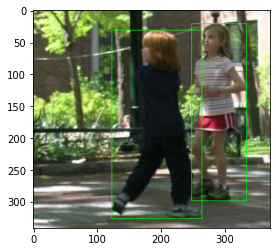

In [11]:
# 데이터 테스트 출력
def tmp_test_dataloader():
  import cv2
  import matplotlib.pyplot as plt

  # 박스 시각화
  def makeBox(voc_im, bbox):
    image = voc_im.copy()
    for i in range(len(bbox)):
      cv2.rectangle(image,(int(bbox[i][0]),int(bbox[i][1])),(int(bbox[i][2]),int(bbox[i][3])),color = (0,255,0),thickness = 1)
    return image


  dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
  dataloader = torch.utils.data.DataLoader(dataset, shuffle=True)

  for i, (image, targets) in enumerate(dataloader):
    test_image = image
    test_target = targets
    if i == 0 : break

  print(test_target)

  plot_image = makeBox(test_image.squeeze(0).permute(1,2,0).numpy(),test_target['boxes'].squeeze(0))
  plt.imshow(plot_image)

tmp_test_dataloader()

In [12]:
def create_faster_rcnn():
    # backbone
    resnet = torchvision.models.resnet50(pretrained=True)
    backbone = nn.Sequential(
        resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool,
        resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4
    )
    backbone.out_channels = 2048


    # anchor generator
    rpn_anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))

    # RPN head
    num_anchors = 5 * 3
    in_channels = backbone.out_channels
    rpn_head = RPNHead(in_channels, num_anchors)

    # roi pooler
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'], output_size=7, sampling_ratio=2)

    # roi head, box base, two mlp head
    in_channles = 7 * 7 * backbone.out_channels
    representation_size = 2048
    box_base = TwoMLPHead(in_channels=in_channles,
                          representation_size=representation_size)
    
    # fast rcnn predictor, box predictor
    num_classes = 2
    box_predictor = FastRCNNPredictor(in_channels=representation_size, num_classes=num_classes)

    # put the pieces together inside a FasterRCNN model
    model = FasterRCNN(backbone,
                       # num_classes=2,
                       rpn_head=rpn_head,
                       rpn_anchor_generator=rpn_anchor_generator,
                       box_roi_pool=roi_pooler,
                       box_head=box_base,
                       box_predictor=box_predictor)
    return model

In [13]:
# faster rcnn inference example

from collections import OrderedDict
from torchvision.models.detection.image_list import ImageList


# assume that original image size : (256, 768) 
@torch.no_grad()
def tmp_test_FasterRCNN():
  faster_rcnn = create_faster_rcnn().eval()
  dummy_img = torch.ones((1, 3, 256, 768))
  dummy_img_list = ImageList(dummy_img, [(256, 768)])

  print(f'{"image shape : " :>25}', dummy_img.shape)
  features = faster_rcnn.backbone(dummy_img_list.tensors)
  print(f'{"feature shape : " :>25}', features.shape)
  if isinstance(features, torch.Tensor):
      features = OrderedDict([("0", features)])


  proposals, _ = faster_rcnn.rpn(dummy_img_list, features)
  print(f'{"proposal shape : " :>25}', proposals[0].shape)

  box_features = faster_rcnn.roi_heads.box_roi_pool(features, proposals, dummy_img_list.image_sizes)
  print(f'{"roi pooling result : " :>25}', box_features.shape)

  box_features = faster_rcnn.roi_heads.box_head(box_features)
  print(f'{"box head output : " :>25}', box_features.shape, '\n')

  class_logits, box_regression = faster_rcnn.roi_heads.box_predictor(box_features)
  boxes, scores, labels = faster_rcnn.roi_heads.postprocess_detections(
      class_logits, box_regression, proposals, dummy_img_list.image_sizes)
  print(f'{"final output shape : " :>25}')
  print('\tboxes :', boxes[0].shape, '\te.g.', boxes[0][0])
  print('\tlabels :', labels[0].shape, '\te.g.', labels[0][0])
  print('\tscores :', scores[0].shape, '\te.g.', scores[0][0])
  print('\tThis output is the result including post-processing such as NMS and Thresholding.')

tmp_test_FasterRCNN()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

           image shape :  torch.Size([1, 3, 256, 768])
         feature shape :  torch.Size([1, 2048, 8, 24])


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


        proposal shape :  torch.Size([468, 4])
    roi pooling result :  torch.Size([468, 2048, 7, 7])
       box head output :  torch.Size([468, 2048]) 

    final output shape : 
	boxes : torch.Size([100, 4]) 	e.g. tensor([119.3547,   0.0000, 567.4575, 256.0000])
	labels : torch.Size([100]) 	e.g. tensor(1)
	scores : torch.Size([100]) 	e.g. tensor(0.5290)
	This output is the result including post-processing such as NMS and Thresholding.


In [14]:
@torch.no_grad()
def tmp_test_backbone():
  resnet = torchvision.models.resnet50(pretrained=True)
  backbone = nn.Sequential(
      resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool,
      resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4,
  )

  input_img = torch.rand(8, 3, 800, 800)
  output_feature = backbone(input_img)
  print('input : image batch {}'.format(input_img.shape))
  print('output : backbone feature {}'.format(output_feature.shape))

tmp_test_backbone()

input : image batch torch.Size([8, 3, 800, 800])
output : backbone feature torch.Size([8, 2048, 25, 25])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


input : images, features  torch.Size([1, 3, 800, 800]), torch.Size([1, 2048, 25, 25])
output : anchors  torch.Size([9375, 4])
tensor([[457., 533., 503., 555.],
        [435., 521., 525., 567.],
        [389., 499., 571., 589.],
        [299., 453., 661., 635.],
        [118., 363., 842., 725.],
        [464., 528., 496., 560.],
        [448., 512., 512., 576.],
        [416., 480., 544., 608.],
        [352., 416., 608., 672.],
        [224., 288., 736., 800.],
        [469., 521., 491., 567.],
        [457., 499., 503., 589.],
        [435., 453., 525., 635.],
        [389., 363., 571., 725.],
        [299., 182., 661., 906.]])


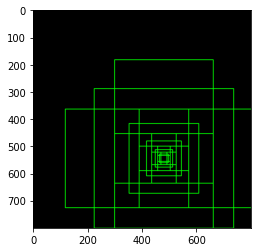

In [15]:
@torch.no_grad()
def tmp_test_anchor_generator(draw_index):
  import cv2
  import matplotlib.pyplot as plt

  rpn_anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))
  rpn_anchor_generator.to('cpu')
  
  images = torch.rand(1, 3, 800, 800)
  features = torch.rand(1, 2048, 25, 25)

  from torchvision.models.detection.image_list import ImageList
  images = ImageList(images, [(800, 800)])

  anchors = rpn_anchor_generator(images, features)

  print('input : images, features  {}, {}'.format(images.tensors.shape, features.shape))
  print('output : anchors  {}'.format(anchors[0].shape)) # 9,375 == 25x25 x 15
  
  draw_img = torch.zeros(800, 800, 3).numpy()
  # 박스 시각화
  def makeBox(voc_im, bbox):
    image = voc_im.copy()
    for i in range(len(bbox)):
      cv2.rectangle(image,(int(bbox[i][0]),int(bbox[i][1])),(int(bbox[i][2]),int(bbox[i][3])),color = (0,255,0),thickness = 2)
    return image

  selected_boxes = anchors[0][15*draw_index:15*(draw_index+1)]

  print(selected_boxes)
  plot_image = makeBox(draw_img, selected_boxes)
  plt.imshow(plot_image)

tmp_test_anchor_generator(440) # 0, 1, 2, 3, ... ,  25*25-2, 25*25-1 까지

In [16]:
@torch.no_grad()
def tmp_test_RPNHead():
  rpn_head = RPNHead(in_channels=2048, num_anchors=5*3) # 2048 : backbone의 output channel

  backbone_feature_map = torch.rand(8, 2048, 25, 25)

  prob, box_delta = rpn_head([backbone_feature_map])
  print('intput : backbone feature {}'.format(backbone_feature_map.shape))
  print('output : prob {}  and  box_delta {}'.format(prob[0].shape, box_delta[0].shape))

tmp_test_RPNHead()

intput : backbone feature torch.Size([8, 2048, 25, 25])
output : prob torch.Size([8, 15, 25, 25])  and  box_delta torch.Size([8, 60, 25, 25])


In [17]:
@torch.no_grad()
def tmp_test_RoIAlign():
  roi_pooler = torchvision.ops.MultiScaleRoIAlign(
          featmap_names=['0'], output_size=7, sampling_ratio=2)

  backbone_feature_map = torch.rand(8, 2048, 25, 25)
  box_of_rpn = [torch.randint(0, 800, size=(100, 4)).float()] * 8   # 8:batch size
  print('[input]')
  print('backbone feature  {}'.format(backbone_feature_map.shape))
  print('box :  batch {}  and  shape : {}'.format(len(box_of_rpn), box_of_rpn[0].shape))
  print()
  print('output : ', roi_pooler(
      x={'0': backbone_feature_map},
      boxes=box_of_rpn,
      image_shapes=[(800, 800)] * 8).shape)
  
tmp_test_RoIAlign()

[input]
backbone feature  torch.Size([8, 2048, 25, 25])
box :  batch 8  and  shape : torch.Size([100, 4])

output :  torch.Size([800, 2048, 7, 7])


In [18]:
@torch.no_grad()
def tmp_test_boxbase():
  box_base = TwoMLPHead(in_channels=7*7*2048,
                            representation_size=2048)

  roi_pooling_result = torch.rand(800, 2048, 7, 7)
  output = box_base(roi_pooling_result)

  print('input : roi pooling result  {}'.format(roi_pooling_result.shape))
  print('output : box base feature  {}'.format(output.shape))

tmp_test_boxbase()

input : roi pooling result  torch.Size([800, 2048, 7, 7])
output : box base feature  torch.Size([800, 2048])


In [19]:
@torch.no_grad()
def tmp_test_boxpredictor():
  num_classes = 81 # e.g. coco : 80 class + 1 background
  box_predictor = FastRCNNPredictor(in_channels=2048, num_classes=num_classes)

  box_base_result = torch.rand(800, 2048)
  prob, box_delta = box_predictor(box_base_result)

  print('input : roi pooling result  {}'.format(box_base_result.shape))
  print('output : box prob  {}   and    box delta {}'.format(prob.shape, box_delta.shape))

tmp_test_boxpredictor()

input : roi pooling result  torch.Size([800, 2048])
output : box prob  torch.Size([800, 81])   and    box delta torch.Size([800, 324])


In [20]:
def create_pretrained_faster_rcnn():
    # COCO 에서 학습된 weight 를 불러오기
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # COCO는 80 클래스. 클래스 개수가 달라졌기에 클래스 분류 layer 를 교체해줘야 함.
    num_classes = 2  # 1 class (person) + background
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [21]:
def create_pretrained_ssd():
    model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(pretrained=True)
    # feature_maps = model.backbone(torch.rand(4, 3, 320, 320))
    # print(len(feature_maps), feature_maps.keys())
    # print(feature_maps['0'].shape, feature_maps['1'].shape, feature_maps['2'].shape,
    #       feature_maps['3'].shape, feature_maps['4'].shape, feature_maps['5'].shape)
    # out = model.head(list(feature_maps.values()))
    # print(out['bbox_regression'].shape, out['cls_logits'].shape)
    return model

In [22]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()

    metric_logger = utils.MetricLogger(delimiter="  ") # 학습할 때 가독성 좋은 log 를 위해 사용
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        # train 할 때는 input image 와 target 이 필요
        # 현재 사용하는 네트워크에 맞게 transform
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        # loss 계산 후 backward  &  파라미터 update
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if not math.isfinite(losses.item()): # loss 가 무한대 되면 강제 정지
            print("Loss is {}, stopping training".format(losses.item()))
            print(loss_dict)
            sys.exit(1)

        # 학습 과정 log
        metric_logger.update(loss=losses, **loss_dict)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

In [23]:
torch.cuda.is_available()

True

In [24]:
if __name__ == "__main__":
    model = main(model_name='faster_rcnn', num_epochs=5)
    '''
    model_name
        faster_rcnn : full modeling and weight initialization
        pretrained_faster_rcnn : coco-pretrained. faster rcnn
        pretrained_ssd : coco-trained. ssdlite320_mobilenet_v3_large
    '''

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [ 0/60]  eta: 0:01:30  lr: 0.005000  loss: 1.5400 (1.5400)  loss_classifier: 0.7355 (0.7355)  loss_box_reg: 0.0189 (0.0189)  loss_objectness: 0.7445 (0.7445)  loss_rpn_box_reg: 0.0411 (0.0411)  time: 1.5140  data: 0.3249  max mem: 5106
Epoch: [0]  [10/60]  eta: 0:00:45  lr: 0.005000  loss: 0.8595 (0.8736)  loss_classifier: 0.2160 (0.3285)  loss_box_reg: 0.0929 (0.1225)  loss_objectness: 0.2861 (0.3679)  loss_rpn_box_reg: 0.0556 (0.0546)  time: 0.9183  data: 0.0385  max mem: 8249
Epoch: [0]  [20/60]  eta: 0:00:36  lr: 0.005000  loss: 0.6714 (0.7788)  loss_classifier: 0.2238 (0.2985)  loss_box_reg: 0.1816 (0.1794)  loss_objectness: 0.1707 (0.2449)  loss_rpn_box_reg: 0.0477 (0.0560)  time: 0.8720  data: 0.0091  max mem: 8250
Epoch: [0]  [30/60]  eta: 0:00:26  lr: 0.005000  loss: 0.5183 (0.6958)  loss_classifier: 0.2238 (0.2733)  loss_box_reg: 0.1901 (0.1780)  loss_objectness: 0.0790 (0.1919)  loss_rpn_box_reg: 0.0411 (0.0527)  time: 0.8670  data: 0.0083  max mem: 8250
Epoch: [

In [25]:
# test data 중 한 장을 가져와서 시각화

data_path = os.path.join('/content/PennFudanPed/PNGImages')
file_list = list(sorted(os.listdir(data_path)))
test_img_path = os.path.join(data_path, file_list[-1])
print(test_img_path)

/content/PennFudanPed/PNGImages/PennPed00096.png


In [26]:
model.eval()

img_path = test_img_path
images = np.array(Image.open(img_path).convert("RGB"))
images = torch.from_numpy(images/255.0).permute(2,0,1).unsqueeze(0).float()
print(images.shape)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

images = list(image.to(device) for image in images)
with torch.no_grad():
  output_dict = model(images)
print(output_dict) 
print(output_dict[0].keys())

torch.Size([1, 3, 331, 294])
[{'boxes': tensor([[  2.2936,  40.9386, 112.0410, 323.0350],
        [106.1715,  25.5170, 198.9298, 312.5633],
        [  6.6652,  53.0389,  50.9693, 308.0558],
        [  2.9967,  84.0310,  25.1506, 280.1839],
        [146.4328,  40.2412, 213.1693, 273.8896],
        [  0.0000,  16.2875, 214.5700, 317.9768]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8647, 0.5456, 0.1870, 0.1807, 0.1419, 0.0746], device='cuda:0')}]
dict_keys(['boxes', 'labels', 'scores'])


In [27]:
# 시각화를 위해서 output 을 numpy 로
boxes = output_dict[0]['boxes'].detach().cpu().numpy()
scores = output_dict[0]['scores'].detach().cpu().numpy()
labels = output_dict[0]['labels'].detach().cpu().numpy()

In [28]:
# score threshold   0.01 v.s. 0.5
# faster rcnn 안에 후처리가 포함되어 있지만, 사용자가 추가로 thresholding 가능

scores_threshold = 0.5  # 0.5
select_idxes = scores > scores_threshold
print(select_idxes)

[ True  True False False False False]


In [29]:
# score thresholding 후 남은 것들만
selected_boxes = boxes[select_idxes].astype(np.int)
selected_scores = scores[select_idxes]
selected_labels = labels[select_idxes]

In [30]:
print(selected_boxes.shape, boxes.shape)  # thresohold 전후

(2, 4) (6, 4)


[[  2  40 112 323]
 [106  25 198 312]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


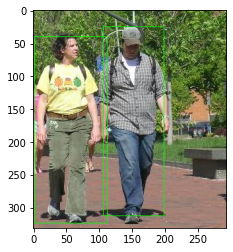

In [31]:
# 데이터 테스트 출력

import cv2
import matplotlib.pyplot as plt

# 박스 시각화
def makeBox(voc_im, bbox):
  image = voc_im.copy()
  for i in range(len(bbox)):
    cv2.rectangle(image,(int(bbox[i][0]),int(bbox[i][1])),(int(bbox[i][2]),int(bbox[i][3])),color = (0,255,0),thickness = 1)
  return image

draw_img = images[0].permute(1, 2, 0).cpu().numpy()
print(selected_boxes)
plot_image = makeBox(draw_img, selected_boxes)
plt.imshow(plot_image)

[실습]

- main 문에서 모델을 바꿔서 AP 성능 비교
  - model = create_faster_rcnn()
  - model = create_pretrained_faster_rcnn()

- threshold 를 바꿔가며 시각화

In [32]:
if __name__ == "__main__":
    # model = main(model_name='faster_rcnn', num_epochs=5)
    model = main(model_name='pretrained_faster_rcnn', num_epochs=1)
    # model = main(model_name='pretrained_ssd', num_epochs=1)
    '''
    model_name
        faster_rcnn : full modeling and weight initialization
        pretrained_faster_rcnn : coco-pretrained. faster rcnn
        pretrained_ssd : coco-trained. ssdlite320_mobilenet_v3_large
    '''

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

Epoch: [0]  [ 0/60]  eta: 0:00:52  lr: 0.005000  loss: 1.0554 (1.0554)  loss_classifier: 0.6990 (0.6990)  loss_box_reg: 0.3434 (0.3434)  loss_objectness: 0.0064 (0.0064)  loss_rpn_box_reg: 0.0067 (0.0067)  time: 0.8751  data: 0.2541  max mem: 9568
Epoch: [0]  [10/60]  eta: 0:00:29  lr: 0.005000  loss: 0.4726 (0.5399)  loss_classifier: 0.1631 (0.2355)  loss_box_reg: 0.2442 (0.2770)  loss_objectness: 0.0175 (0.0201)  loss_rpn_box_reg: 0.0047 (0.0073)  time: 0.5802  data: 0.0311  max mem: 9568
Epoch: [0]  [20/60]  eta: 0:00:22  lr: 0.005000  loss: 0.2644 (0.4075)  loss_classifier: 0.0631 (0.1471)  loss_box_reg: 0.1756 (0.2398)  loss_objectness: 0.0075 (0.0130)  loss_rpn_box_reg: 0.0037 (0.0077)  time: 0.5442  data: 0.0084  max mem: 9568
Epoch: [0]  [30/60]  eta: 0:00:16  lr: 0.005000  loss: 0.2293 (0.3490)  loss_classifier: 0.0467 (0.1155)  loss_box_reg: 0.1721 (0.2163)  loss_objectness: 0.0014 (0.0096)  loss_rpn_box_reg: 0.0061 (0.0076)  time: 0.5535  data: 0.0082  max mem: 9568
Epoch: [